In [4]:
# 📓 Customer Retention Analysis: 03_cohort_retention.ipynb

## 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")

## 2. Load Processed Data
data = pd.read_csv("../data/processed/customer_data.csv")

## 3. Simulate Order Dates for Each Customer

records = []
np.random.seed(42)
for _, row in data.iterrows():
    num_orders = int(row["TotalOrders"])
    base_date = datetime(2023, 1, 1)
    for i in range(num_orders):
        days_offset = np.random.randint(0, 180)
        order_date = base_date + timedelta(days=int(days_offset))
        records.append({
            "CustomerID": row["CustomerID"],
            "OrderDate": order_date.date()
        })

orders_df = pd.DataFrame(records)


In [5]:

## 4. Assign Cohort Month
orders_df['OrderMonth'] = pd.to_datetime(orders_df['OrderDate']).dt.to_period('M')
cohort_data = orders_df.groupby('CustomerID')['OrderMonth'].min().reset_index()
cohort_data.columns = ['CustomerID', 'CohortMonth']

# Merge to orders
orders_df = orders_df.merge(cohort_data, on='CustomerID')

# Calculate CohortIndex
orders_df['CohortIndex'] = (
    orders_df['OrderMonth'].dt.to_timestamp().dt.to_period('M').astype('int') -
    orders_df['CohortMonth'].dt.to_timestamp().dt.to_period('M').astype('int')
) + 1

## 5. Retention Matrix (in %)
cohort_pivot = orders_df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().unstack(0)
cohort_size = cohort_pivot.iloc[0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=1).round(2) * 100
retention_matrix = retention_matrix.fillna(0).astype(int)


🔁 Retention Matrix (%):


CohortMonth,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06
CohortIndex,,,,,,
1,100,100,100,100,100,100
2,35,33,34,36,32,0
3,25,40,40,31,0,0
4,33,43,32,0,0,0
5,35,50,0,0,0,0
6,31,0,0,0,0,0


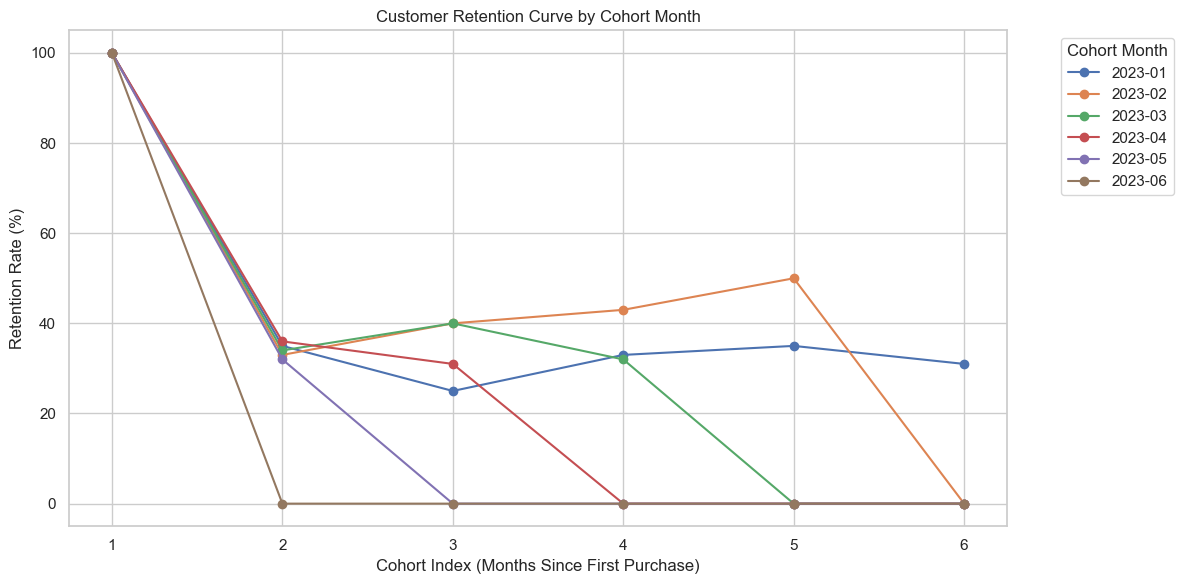

In [6]:

# Save matrix for reporting
retention_matrix.to_csv("../data/processed/retention_matrix.csv")

## 6. Display Retention Table
print("🔁 Retention Matrix (%):")
display(retention_matrix)

## 7. Plot Retention Curve
plt.figure(figsize=(12, 6))
for cohort_month in retention_matrix.columns:
    plt.plot(retention_matrix.index, retention_matrix[cohort_month], marker='o', label=str(cohort_month))

plt.title('Customer Retention Curve by Cohort Month')
plt.xlabel('Cohort Index (Months Since First Purchase)')
plt.ylabel('Retention Rate (%)')
plt.xticks(retention_matrix.index)
plt.legend(title='Cohort Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
